In [1]:
message("Loading packages")
suppressMessages({
library('ggplot2')
library('readr')
library('reshape2')
library('plyr')
library('tidyverse')
library('dplyr')
library('glue')
library('seqinr')
library('stringr')
library('gggenes')
library("pals")
library("ggrepel")
})

Loading packages



In [2]:
message("Set up working directory")

wkdir = '/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mirella_immuno'

setwd(wkdir)

Set up working directory



In [3]:
# input parameters: 
min_varfreq = 0.02  # min minor freq cutoff

varcov = 200  # min minor rd cutoff

percent_cut = 0.75  # breadth of cov

coverage_cut = 5  # min required cov for consensus

project = 'rdv_resistance'

In [4]:
# filenames and functions: 
source(glue('{wkdir}/resistance_project/scripts/rdv_resistance.extra.R')) # LOAD IN FUNCTIONS

gene_info = read.csv(glue('{wkdir}/../../reference/sars/sars_nih_ref/sars-cov-2-features.5.csv')) 

metafile = glue("{wkdir}/resistance_project/metadata/20240128.FINAL.v2.csv")

medfilename = glue("{wkdir}/resistance_project/metadata/treatments.FINAL.20240128.csv")

replicate_info = read.csv(glue('{wkdir}/resistance_project/metadata/20240128_replicates_info.v3.csv'),header=T,sep=",",na.strings = c('')) # changed the 1.5 values to 1 and 2

nygc_rep_info = read.csv(glue("{wkdir}/resistance_project/metadata/20240128.nygc.rep.data.csv"),header=T,sep=",",na.strings = c(''))

consensus_file = glue('{wkdir}/resistance_project/variants/all/COV19.consensus.5.all.csv')

minor_varfile = glue('{wkdir}/resistance_project/variants/all/COV19.minor.50.0.01.all.csv')

In [5]:
message("Generate necessary directories")

FIG_DIR = glue("{wkdir}/resistance_project/figures/")


if (!dir.exists(FIG_DIR)) {
      dir.create(FIG_DIR)
    }

message('figures will be saved in: ', FIG_DIR)

Generate necessary directories

figures will be saved in: /Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mirella_immuno/resistance_project/figures/



## Prepping the Metadata: 

In [6]:
# reading in the metadata file, setting the dates, and removing the samples that aren't part of the RDV cohort
meta = read.csv(file= metafile,header=T,sep=",",na.strings = c('')) %>%
    mutate(first_positive = as.Date(first_positive),
           last_seq_date = as.Date(last_seq_date),
           collection_date = as.Date(collection_date),
           to_diagnosis = as.numeric(difftime(collection_date, first_positive, unit = 'days')), 
           first_positive_last_seq = as.numeric(difftime(last_seq_date, first_positive, unit = 'days'))) %>%
    unique()

meta = meta %>% filter(!sample_id %in% remove_2646 & !name %in% removeit)

In [7]:
# adding in metadata, adjusting the dates, calculating differences in dates for the treatments:
medfile = merge(read.csv(file=medfilename, header=T, sep=",", na.strings = c('')),
                meta %>% 
                select(Patient.number, first_positive, last_seq_date, clade), by = c('Patient.number')) %>%
                mutate(start_date = as.Date(start_date,"%m/%d/%y"),
                       end_date = as.Date(end_date,"%m/%d/%y"),
                       diff_from_final_seq = as.numeric(difftime(start_date, last_seq_date, unit = 'days')),
                       start_first = as.numeric(difftime(start_date, first_positive, unit = 'days')),
                       end_first = as.numeric(difftime(end_date, first_positive, unit = 'days'))) %>%
    unique()

In [8]:
# setting up the med color scale
meds = c(levels(factor((medfile %>% filter(treatment!= 'NA'))$treatment_type)))

treatment_color_list =  as.vector(kelly(20))[5:15]

names(treatment_color_list) = c(meds)

treat_colScale_fill = scale_fill_manual(name = "med",values = treatment_color_list)

treat_colScale = scale_colour_manual(name = "med",values = treatment_color_list)

In [9]:
# pulling out the clade information for the figure
temp = meta %>% 
        select(Patient.number, to_diagnosis, first_positive_last_seq, clade) %>% 
        unique()

write.csv(temp, 
         glue("{wkdir}/metadata/summary.data.fig1a.1.csv"),
         row.names = FALSE)

In [10]:
# for source data:
write.csv(medfile %>% filter(treatment %in% pull_treatments & 
                                           start_first > -14 & diff_from_final_seq < 14 & 
                                           treatment != "NA" | 
                  treatment == 'paxlovid') %>%
            select(Patient.number, treatment, start_first, end_first) %>% unique() %>%
            arrange(Patient.number, start_first),
           glue("{wkdir}/metadata/source.data.fig1a.meds.csv"),
           row.names = FALSE)

Warning message:
“Removed 13 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


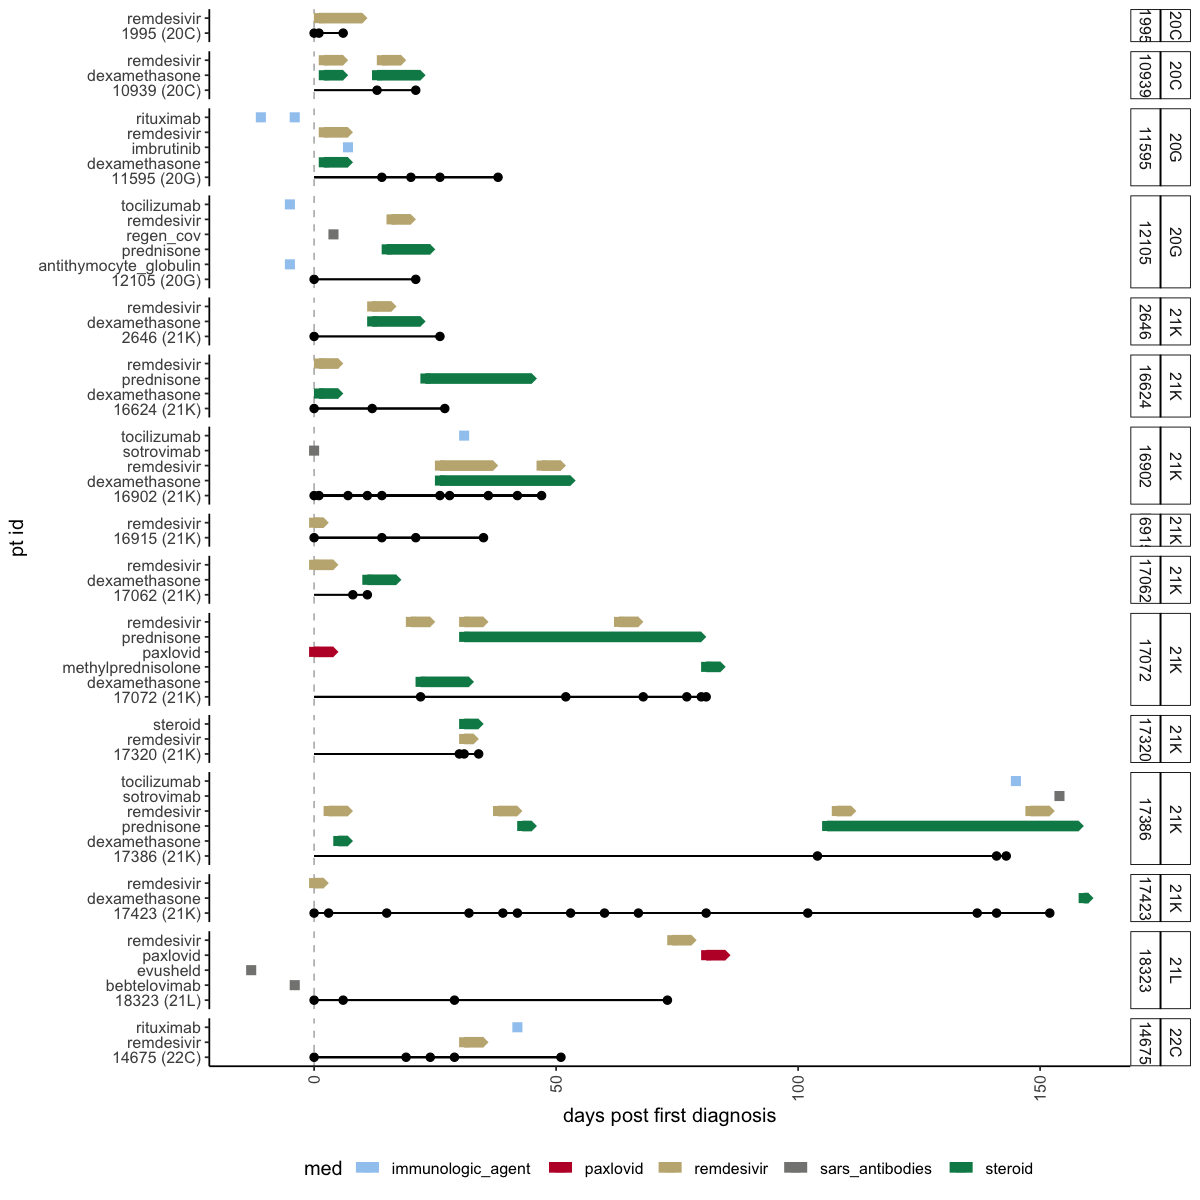

In [11]:
### FIGURE 1
options(repr.plot.width = 10, repr.plot.height = 10)

p3 = ggplot() + 

    geom_vline(xintercept = 0, linetype = 2, color = 'gray') + 
    
    geom_segment(data = medfile %>% filter(treatment %in% pull_treatments & 
                                           start_first > -14 & diff_from_final_seq < 14 & 
                                           treatment != "NA"),
                 aes(x=start_first, xend = end_first,
                     y = glue("{treatment}"), 
                     yend = glue("{treatment}"), 
                     color = treatment_type), linewidth = 3) + 

    geom_point(data = medfile %>% filter(treatment %in% pull_treatments & 
                                         start_first > -14 & diff_from_final_seq < 14 &
                                         treatment != "NA"),
                 aes(x=start_first,
                     y = glue("{treatment}"), 
                     color = treatment_type), size = 2.5, shape = 15) + 

    geom_point(data = medfile %>% filter(treatment %in% pull_treatments & 
                                         start_first > -14 & diff_from_final_seq < 14 & treatment != "NA"),
                 aes(x=end_first,
                     y = glue("{treatment}"), 
                     color = treatment_type), size = 2.5, shape = 18) + 

    geom_segment(data = temp,
                 aes(yend = glue("{Patient.number} ({clade})"), y = glue("{Patient.number} ({clade})"), x = 0, xend = first_positive_last_seq)) + 
    
    geom_point(data = temp, aes(x=to_diagnosis, y = glue("{Patient.number} ({clade})")), 
               size = 2) + 

    PlotTheme1 +
    treat_colScale_fill + 
    treat_colScale + 
    labs(y = 'pt id', x = "days post first diagnosis") +
    facet_grid(clade + Patient.number ~., space = 'free', scales = 'free') +
    theme(legend.position = 'bottom')

p3


In [12]:
ggsave(p3,
       filename = glue("{FIG_DIR}/FIGURE1.png"),
       width = 8,
       height = 11, limitsize=FALSE)

ggsave(p3,
       filename = glue("{FIG_DIR}/FIGURE1.pdf"),
       width = 8,
       height = 11, limitsize=FALSE, useDingbats = FALSE)


Warning message:
“Removed 13 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


## Prepping data to compare sequencing replicates: 
- Replicate seq data were on different runs and often named differently. Here we prep the data and metadata so we can accurately compare replicate data to each other. The two replicates were selected based on their coverage data.

In [13]:
replicate_info = replicate_info %>%
    mutate(collection_date =as.Date(collection_date, "%m/%d/%y"))

one = rbind(grab_replicates(replicate_info, "percentage1", "run_name1"), nygc_rep_info) %>%
    mutate(adjusted_name = glue("{name}_r1"),
          run = 1)

two = grab_replicates(replicate_info, "percentage2", "run_name2") %>%
    mutate(adjusted_name = glue("{name}_r2"),
          run = 2)

three = grab_replicates(replicate_info, "percentage3", "run_name3") %>%
    mutate(adjusted_name = glue("{name}_r3"),
          run = 3)

reps = rbind(one, two, three)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(coltype)

  # Now:
  data %>% select(all_of(coltype))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


## Loading in consensus data and adjusting to bind with minor data: 

In [14]:
confile = merge(reps, read.csv(consensus_file, header=T, sep=",", na.strings = c('')) %>%
                        filter(name %in% reps$adjusted_name) %>% 
                        select(all_of(select_cols)), 
    by.x = c('adjusted_name'),
    by.y = c('name'), 
    all.y = TRUE)

In [15]:
varfile = merge(reps,read.csv(minor_varfile,header=T,sep=",",na.strings = c('')) %>%
                        filter(name %in% reps$adjusted_name) %>% # has them combined now
                        select(all_of(select_cols)), 
    by.x = c('adjusted_name'),
    by.y = c('name'), 
    all.y = TRUE)

In [16]:
# separating out the two replicates:
con1 = confile %>% filter(Order == 1 | Order == 0) # best rep or is from nygc

con2 = confile %>% filter(Order == 2 | Order == 0)

var1 = varfile %>% filter(Order == 1 | Order == 0)

var2 = varfile %>% filter(Order == 2| Order == 0)



con1 = con1 %>% select(all_of(pull_major_columns2)) %>% drop_na(major) %>%
    rename("varnt" = "major", 
           "varfreq" = "majorfreq",
            "varaa" = "majoraa", 
           "varcodon" = "majorcodon") %>%
        mutate(majnt = varnt)

var1_2 = var1 %>% select(all_of(pull_major_columns2))%>% drop_na(major) %>% 
        rename("varnt" = "major", 
               "varfreq" = "majorfreq",
                "varaa" = "majoraa", 
               "varcodon" = "majorcodon") %>%
        mutate(majnt = varnt)

var1 = var1 %>% select(all_of(pull_minor_columns2))%>% drop_na(minor) %>% rename("varnt" = "minor", 
           "varfreq" = "minorfreq",
            "varaa" = "minoraa", 
           "varcodon" = "minorcodon",
            "majnt" = "major") 


ALL1 = rbind(con1, var1, var1_2) %>% unique()

In [17]:
rm(con1, var1, var1_2)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1246884,66.6,46496460,2483.2,58120575,3104.0
Vcells,152883339,1166.5,351156935,2679.2,328125424,2503.4


In [18]:
con2 = con2 %>% select(all_of(pull_major_columns2)) %>% drop_na(major) %>%
    rename("varnt" = "major", 
           "varfreq" = "majorfreq",
            "varaa" = "majoraa", 
           "varcodon" = "majorcodon") %>%
        mutate(majnt = varnt)

var2_2 = var2 %>% select(all_of(pull_major_columns2))%>% drop_na(major) %>% 
        rename("varnt" = "major", 
               "varfreq" = "majorfreq",
                "varaa" = "majoraa", 
               "varcodon" = "majorcodon") %>%
        mutate(majnt = varnt)

var2 = var2 %>% select(all_of(pull_minor_columns2))%>% drop_na(minor) %>% rename("varnt" = "minor", 
           "varfreq" = "minorfreq",
            "varaa" = "minoraa", 
           "varcodon" = "minorcodon",
            "majnt" = "major") 

ALL2 = rbind(con2, var2, var2_2) %>% unique()

In [19]:
ALL_DF = merge(ALL1, ALL2, by = c('sample_id', 'Patient.number', 'collection_date',
                        'segment','gene_id','ntpos','varnt','refnt','aapos','varaa','varcodon'), 
              all = TRUE)

In [20]:
rm(var2, con2, var2_2)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1252222,66.9,29757735,1589.3,58120575,3104.0
Vcells,187296759,1429.0,431736446,3293.9,431736446,3293.9


In [21]:
ALL_DF = PrepDF(ALL_DF, ntlist, aminoacids, coverage_cut, min_varfreq) # adjust w/ rep information

In [22]:
# reducing down metadata to merge with: 
merge_meta = meta %>% select(-type, -name, -Order) %>%
                 mutate(collection_date = as.Date(collection_date)) %>%
            unique()

In [23]:
FILT_DF = FilterDF(ALL_DF, merge_meta, nsps)

## Prepping the correct reference information: 


In [24]:
# rbind all the reference files
aadfs = Sys.glob(glue("{wkdir}/resistance_project/reference/*aadf.csv"), dirmark = FALSE)
ntdfs = Sys.glob(glue("{wkdir}/resistance_project/reference/*ntdf.csv"), dirmark = FALSE)
aadf = cat_dfs(aadfs, 'aa')
ntdf = cat_dfs(ntdfs, 'nt')


## "Total Var" dataframe = consensus and minor variant together

In [25]:
total_var = CombineVar(FILT_DF, ntdf, aadf, aminoacids)

In [26]:
# filter for those fixed mutations - likely strain specific differences
fixed_mutations = total_var %>%
    filter(varfreq > 0.98) %>%
    unique()


In [27]:
total_var %>% filter(varfreq >= 0.02 & varfreq <= 1 & varaa != aa) %>% # filter for patient info
            select(Patient.number, gene_id, aapos, varaa, aa) %>%
            unique() %>%
            group_by(Patient.number, gene_id) %>% # group by patient info and collection date
            add_tally() %>%
    filter(gene_id %in% c('nsp5','nsp12b')) %>% 
    select(Patient.number, gene_id, n) %>%
    unique()

Patient.number,gene_id,n
<int>,<chr>,<int>
1995,nsp12b,1
11595,nsp12b,7
17320,nsp12b,1
16902,nsp12b,2
12105,nsp12b,1
17072,nsp12b,3
16915,nsp12b,1
17423,nsp12b,2
18323,nsp5,1


## Patient figures: 

### 17072

In [28]:
pt = 17072
minfreq = 0.02
maxfreq = 1 # using a max of 1 bc some emerged and became fixed w/in the host
ptdf = GeneratePatientDF(total_var, pt, minfreq, maxfreq)
pt_med = medfile %>% filter(Patient.number == pt & treatment %in% c('remdesivir', 'paxlovid')) # only want to show antiviral data with var
first_date = as.Date(levels(factor(ptdf$first_positive)))

In [29]:
write.csv(total_var %>% 
        filter(Patient.number == pt & varfreq >= minfreq & varfreq <= maxfreq) %>% # & varaa != aa) %>%
        group_by(sample_id, Patient.number, to_diagnosis) %>%
        add_tally() %>%
        ungroup() %>%
    select(Patient.number, to_diagnosis, n) %>%
    arrange(to_diagnosis) %>%
    unique(),
          glue("{wkdir}/metadata/{pt}.total.snv.csv"),
          row.names = FALSE)

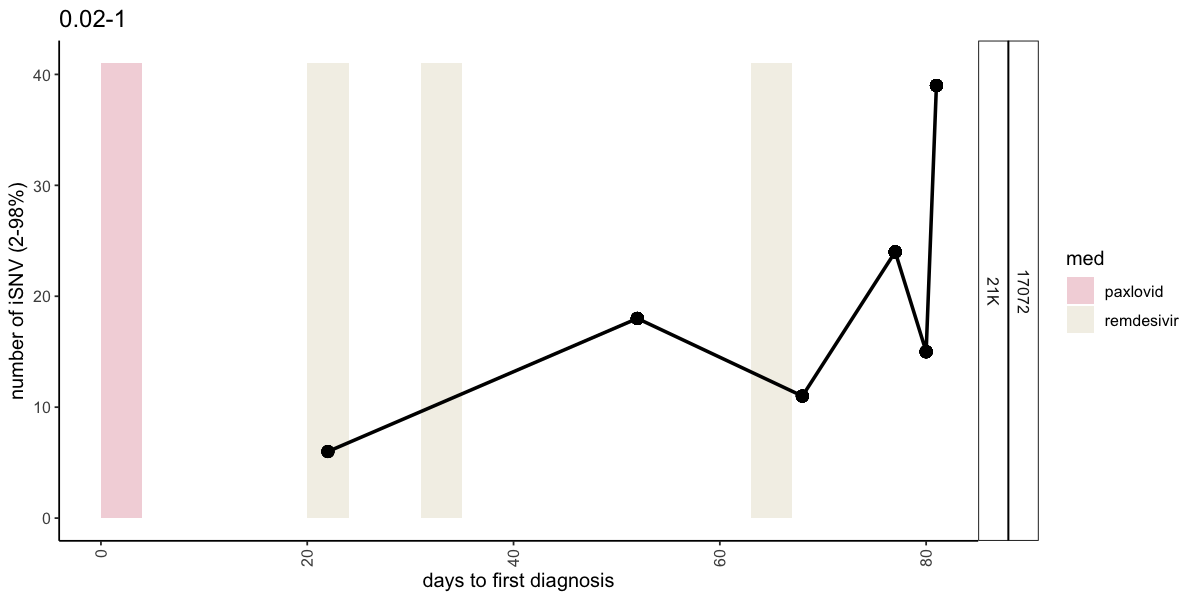

In [30]:
# number of isnv
options(repr.plot.width = 10, repr.plot.height = 5)

p6 = plot_isnv(pt, pt_med, ptdf, treat_colScale_fill, first_date) +
    ggtitle(glue("{minfreq}-{maxfreq}"))
p6

ggsave(p6,
       filename = glue("{FIG_DIR}/pt{pt}.total.isnv.{minfreq}.pdf"),
       width = 7,
       height = 2.5, limitsize=FALSE, useDingbats = FALSE)

In [31]:
write.csv(source_data(ALL_DF, pt, ptdf %>% filter(varaa != aa & gene_id %in% c('nsp5','nsp12b')), pt_med, first_date, aa_colScale, gene_ord_list2),
          glue("{wkdir}/metadata/{pt}.nsp5.nsp12.csv"),
          row.names = FALSE)

[1] "nsp5"   "nsp12b"


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


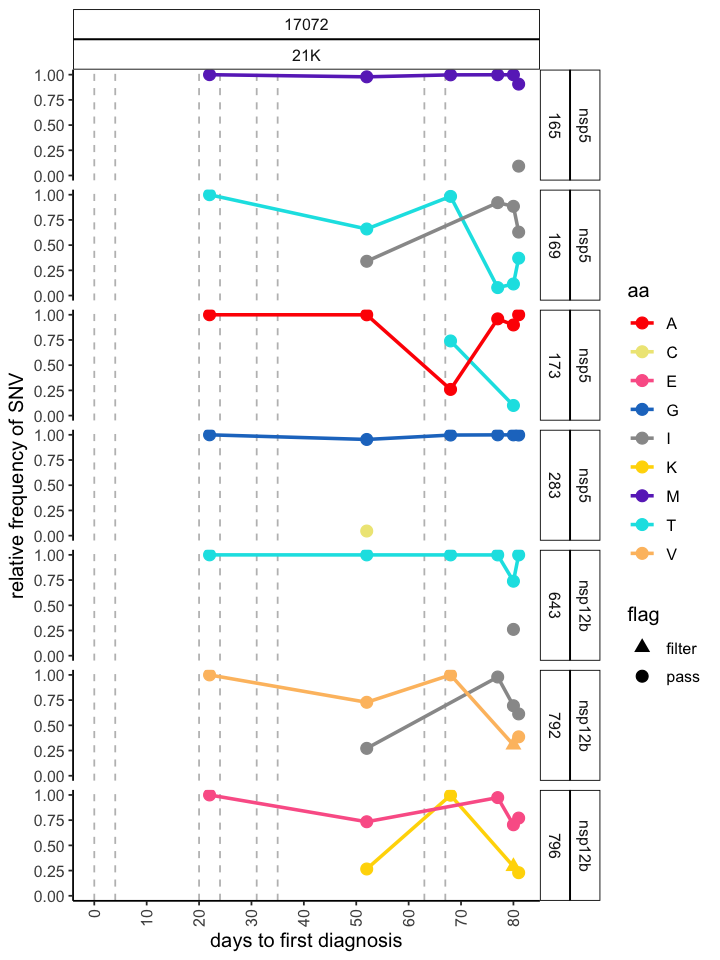

In [32]:
options(repr.plot.width = 6, repr.plot.height = 8)

p0 = plot_frequency(ALL_DF, pt, ptdf %>% filter(varaa != aa & gene_id %in% c('nsp5','nsp12b')), pt_med, first_date, aa_colScale, gene_ord_list2)

print(p0)

ggsave(p0,
       filename = glue("{FIG_DIR}/pt{pt}.isnv.{minfreq}.pdf"),
       width = 7,
       height = 10, limitsize=FALSE, useDingbats = FALSE)

In [33]:
temp = ALL_DF %>% 
                filter(!gene_id %in% c('nsp12b', 'nsp5', 'ORF1a', 'ORF1b') &
                            Patient.number == pt & 
                            ntpos %in% (ptdf %>% filter(number_of_samples >1 & varaa != aa))$ntpos) %>% 
                select(Patient.number, collection_date,gene_id,varfreq, aapos, varnt, varaa, ntpos, filt_flag) %>% 
                unique() %>%
    mutate(to_diagnosis = as.numeric(collection_date - first_date))


write.csv(temp, 
         glue("{wkdir}/metadata/{pt}.supp_data.csv"),
         row.names = FALSE)

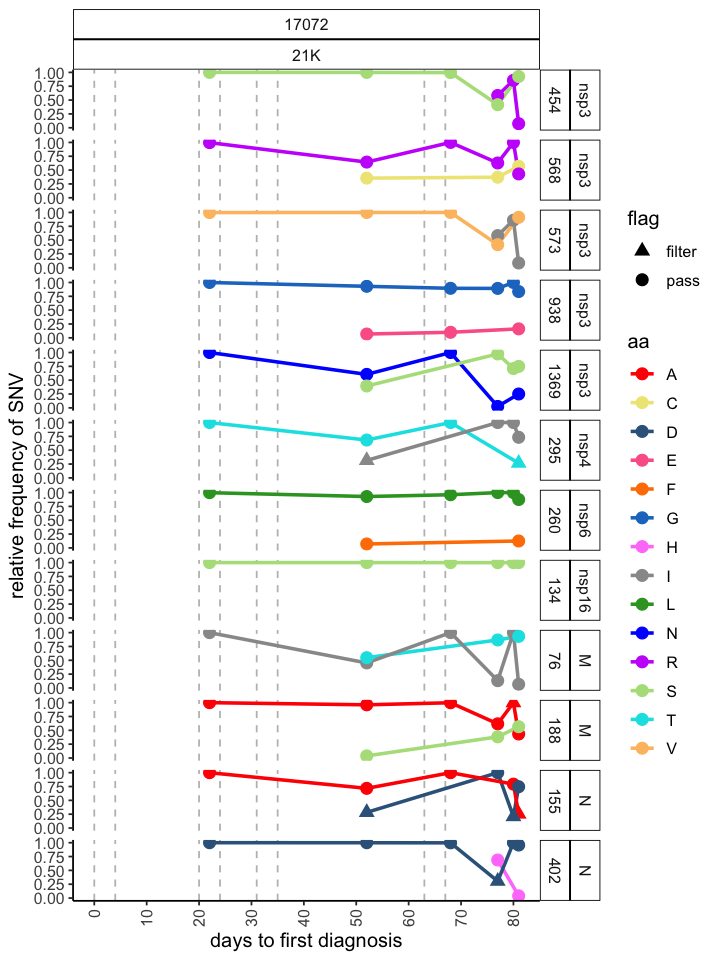

In [34]:
options(repr.plot.width = 6, repr.plot.height = 8)

pt_med = medfile %>% filter(Patient.number == pt & treatment %in% c('remdesivir', 'paxlovid', 'sotrovimab'))

p0 = plot_frequency(ALL_DF, pt, ptdf %>% filter(varaa != aa & 
                                                          number_of_samples > 1 & 
                                                          !gene_id %in% c('nsp12b', 'nsp5') 
                                                         ), pt_med, first_date, aa_colScale, gene_ord_list2)

p0
ggsave(p0,
       filename = glue("{FIG_DIR}/pt{pt}.isnv.{minfreq}.all.pdf"),
       width = 5,
       height = 10, limitsize=FALSE, useDingbats = FALSE)

## Patient 11595

In [35]:
pt = 11595
minfreq = 0.02
maxfreq = 1 # using a max of 1 bc some emerged and became fixed w/in the host
ptdf = GeneratePatientDF(total_var, pt, minfreq, maxfreq)
pt_med = medfile %>% filter(Patient.number == pt & treatment %in% c('remdesivir', 'paxlovid')) # only want to show antiviral data with var
first_date = as.Date(levels(factor(ptdf$first_positive)))

In [36]:
write.csv(total_var %>% 
        filter(Patient.number == pt & varfreq >= minfreq & varfreq <= maxfreq) %>% # & varaa != aa) %>%
        group_by(sample_id, Patient.number, to_diagnosis) %>%
        add_tally() %>%
        ungroup() %>%
    select(Patient.number, to_diagnosis, n) %>%
    arrange(to_diagnosis) %>%
    unique(),
          glue("{wkdir}/metadata/{pt}.total.snv.csv"),
          row.names = FALSE)

In [37]:
write.csv(source_data(ALL_DF, pt, ptdf %>% filter(varaa != aa & gene_id %in% c('nsp5','nsp12b')), pt_med, first_date, aa_colScale, gene_ord_list2),
          glue("{wkdir}/metadata/{pt}.nsp5.nsp12.csv"),
          row.names = FALSE)

[1] "nsp12b"


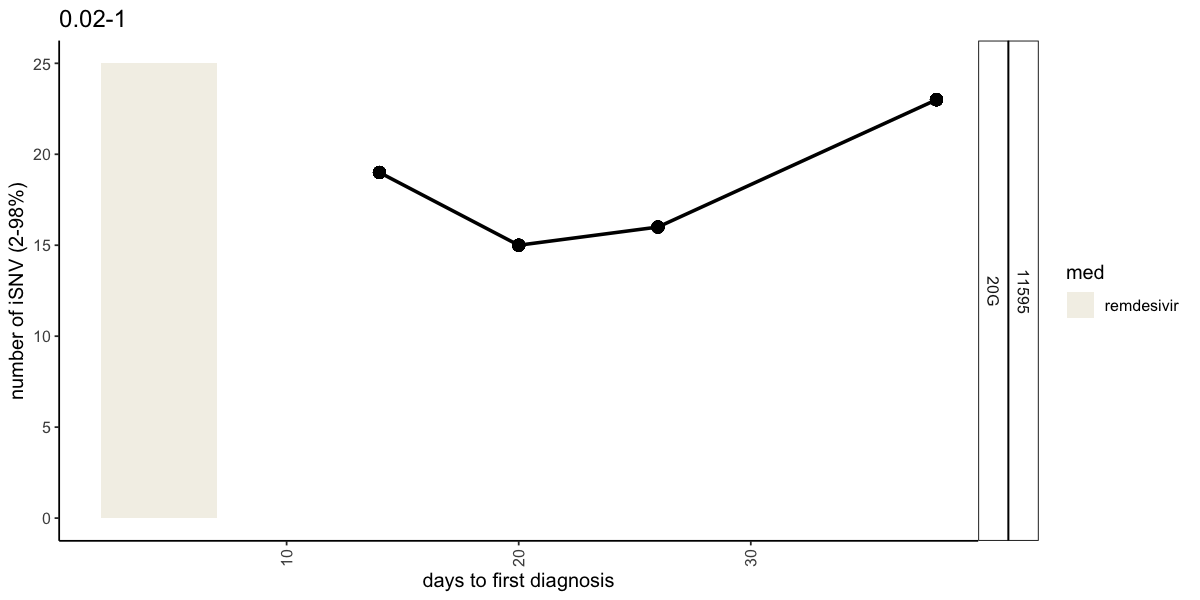

In [38]:
options(repr.plot.width = 10, repr.plot.height = 5)
p6 = plot_isnv(pt, pt_med, ptdf, treat_colScale_fill, first_date) +
    ggtitle(glue("{minfreq}-{maxfreq}"))
p6


ggsave(p6,
       filename = glue("{FIG_DIR}/pt{pt}.total.isnv.{minfreq}.pdf"),
       width = 7,
       height = 2.5, limitsize=FALSE, useDingbats = FALSE)


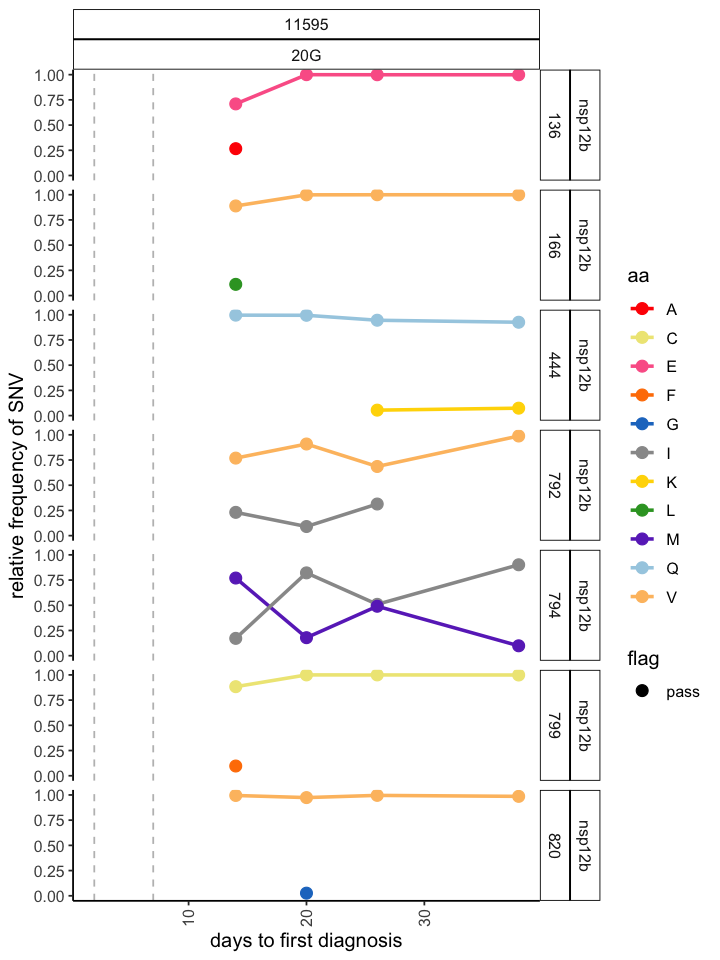

In [39]:
options(repr.plot.width = 6, repr.plot.height = 8)

p0 = plot_frequency(ALL_DF, pt, ptdf %>% filter(varaa != aa & gene_id %in% c('nsp5','nsp12b')), pt_med, first_date, aa_colScale, gene_ord_list2)

print(p0)

ggsave(p0,
       filename = glue("{FIG_DIR}/pt{pt}.isnv.{minfreq}.pdf"),
       width = 7,
       height = 10, limitsize=FALSE, useDingbats = FALSE)

In [40]:
temp = ALL_DF %>% 
                filter(!gene_id %in% c('nsp12b', 'nsp5', 'ORF1a', 'ORF1b') &
                            Patient.number == pt & 
                            ntpos %in% (ptdf %>% filter(number_of_samples >1 & varaa != aa))$ntpos) %>% 
                select(Patient.number, collection_date,gene_id,varfreq, aapos, varnt, varaa, ntpos, filt_flag) %>% 
                unique() %>%
    mutate(to_diagnosis = as.numeric(collection_date - first_date))


write.csv(temp, 
         glue("{wkdir}/metadata/{pt}.supp_data.csv"),
         row.names = FALSE)

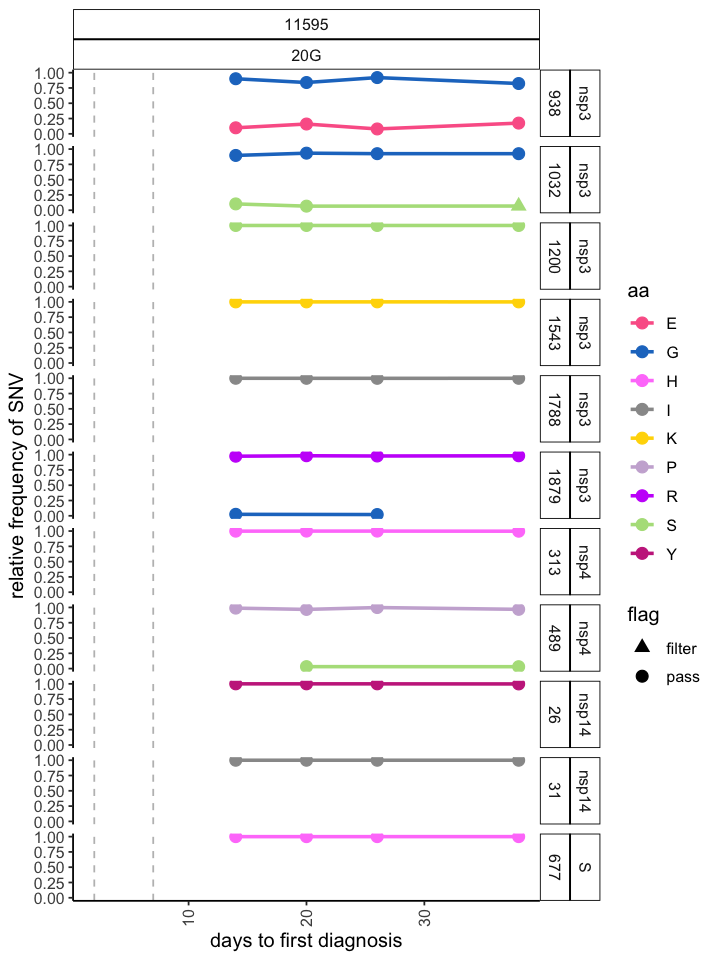

In [41]:
options(repr.plot.width = 6, repr.plot.height = 8)

pt_med = medfile %>% filter(Patient.number == pt & treatment %in% c('remdesivir', 'paxlovid', 'sotrovimab'))

p0 = plot_frequency(ALL_DF, pt, ptdf %>% filter(varaa != aa & 
                                                          number_of_samples > 1 & 
                                                          !gene_id %in% c('nsp12b', 'nsp5') 
                                                         ), pt_med, first_date, aa_colScale, gene_ord_list2)

p0
ggsave(p0,
       filename = glue("{FIG_DIR}/pt{pt}.isnv.{minfreq}.all.pdf"),
       width = 5,
       height = 8, limitsize=FALSE, useDingbats = FALSE)

## Patient 16902

In [42]:
pt = 16902
minfreq = 0.02
maxfreq = 1 # using a max of 1 bc some emerged and became fixed w/in the host
ptdf = GeneratePatientDF(total_var, pt, minfreq, maxfreq)
pt_med = medfile %>% filter(Patient.number == pt & treatment %in% c('remdesivir', 'paxlovid')) # only want to show antiviral data with var
first_date = as.Date(levels(factor(ptdf$first_positive)))

In [43]:
write.csv(total_var %>% 
        filter(Patient.number == pt & varfreq >= minfreq & varfreq <= maxfreq) %>% # & varaa != aa) %>%
        group_by(sample_id, Patient.number, to_diagnosis) %>%
        add_tally() %>%
        ungroup() %>%
    select(Patient.number, to_diagnosis, n) %>%
    arrange(to_diagnosis) %>%
    unique(),
          glue("{wkdir}/metadata/{pt}.total.snv.csv"),
          row.names = FALSE)

write.csv(source_data(ALL_DF, pt, ptdf %>% filter(varaa != aa & gene_id %in% c('nsp5','nsp12b')), pt_med, first_date, aa_colScale, gene_ord_list2),
          glue("{wkdir}/metadata/{pt}.nsp5.nsp12.csv"),
          row.names = FALSE)

[1] "nsp12b"


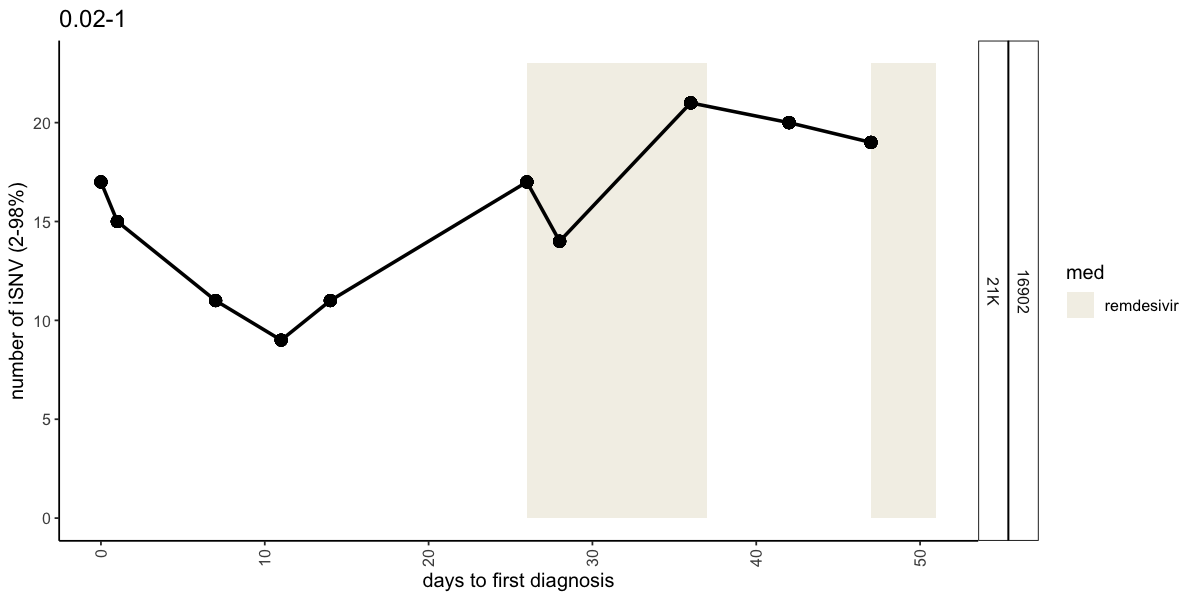

In [44]:
options(repr.plot.width = 10, repr.plot.height = 5)

p6 = plot_isnv(pt, pt_med, ptdf, treat_colScale_fill, first_date) +
    ggtitle(glue("{minfreq}-{maxfreq}"))

p6

ggsave(p6,
       filename = glue("{FIG_DIR}/pt{pt}.total.isnv.{minfreq}.pdf"),
       width = 7,
       height = 2.5, limitsize=FALSE, useDingbats = FALSE)

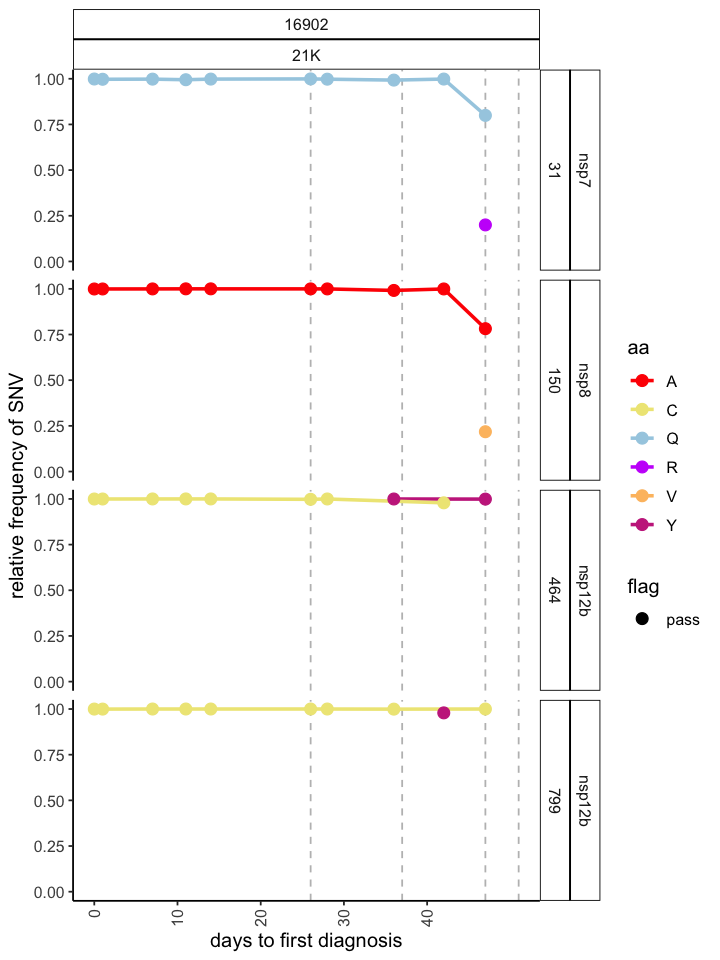

In [45]:
options(repr.plot.width = 6, repr.plot.height = 8)

p0 = plot_frequency(ALL_DF, pt, ptdf %>% filter(varaa != aa & gene_id %in% c('nsp5','nsp7','nsp8','nsp12b')), pt_med, first_date, aa_colScale, gene_ord_list2)

print(p0)

ggsave(p0,
       filename = glue("{FIG_DIR}/pt{pt}.isnv.{minfreq}.pdf"),
       width = 7,
       height = 5, limitsize=FALSE, useDingbats = FALSE)

Warning message:
“Removed 10 rows containing missing values (`geom_vline()`).”
Warning message:
“Removed 10 rows containing missing values (`geom_vline()`).”


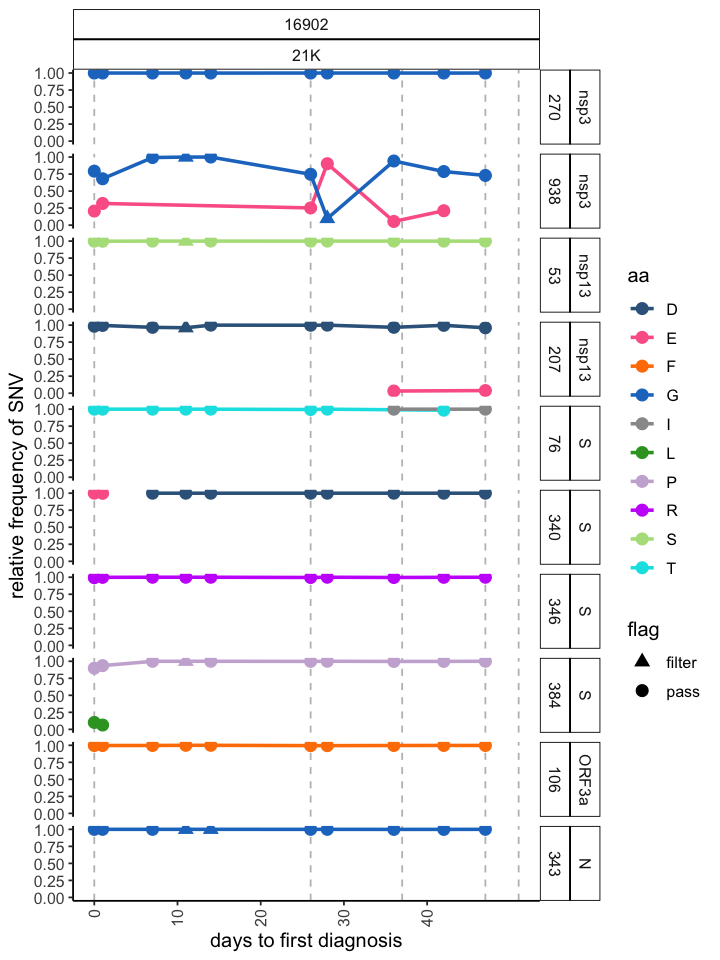

In [46]:
options(repr.plot.width = 6, repr.plot.height = 8)

pt_med = medfile %>% filter(Patient.number == pt & treatment %in% c('remdesivir', 'paxlovid', 'sotrovimab'))

p0 = plot_frequency(ALL_DF, pt, ptdf %>% filter(varaa != aa & 
                                                          number_of_samples > 1 & 
                                                          !gene_id %in% c('nsp12b', 'nsp5') 
                                                         ), pt_med, first_date, aa_colScale, gene_ord_list2)

p0
ggsave(p0,
       filename = glue("{FIG_DIR}/pt{pt}.isnv.{minfreq}.all.pdf"),
       width = 5,
       height = 8, limitsize=FALSE, useDingbats = FALSE)

In [47]:
temp = ALL_DF %>% 
                filter(!gene_id %in% c('nsp12b', 'nsp5', 'ORF1a', 'ORF1b') &
                            Patient.number == pt & 
                            ntpos %in% (ptdf %>% filter(number_of_samples >1 & varaa != aa))$ntpos) %>% 
                select(Patient.number, collection_date, gene_id,varfreq, aapos, varnt, varaa, ntpos, filt_flag) %>% 
                unique() %>%
    mutate(to_diagnosis = as.numeric(collection_date - first_date))


write.csv(temp, 
         glue("{wkdir}/metadata/{pt}.supp_data.csv"),
         row.names = FALSE)

In [48]:
# supp table: 
total_var %>% filter(gene_id %in% c('nsp5', 'nsp12b') & varaa != aa &  filt_flag == 'pass') %>%
    group_by(Patient.number, gene_id, aa, varaa, aapos) %>%
    mutate(min = min(varfreq),
          max = max(varfreq),
          n = n(), 
          aapos = ifelse(gene_id == 'nsp12b', aapos + 9, aapos),
          gene_id = ifelse(gene_id == 'nsp12b', 'nsp12', gene_id)) %>%
    ungroup() %>%
    select(Patient.number, gene_id, aapos, aa, varaa, min, max, n) %>%
    unique() %>%
    arrange(Patient.number)

Patient.number,gene_id,aapos,aa,varaa,min,max,n
<int>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
1995,nsp12,16,A,V,0.99892751,1.00000000,3
10939,nsp5,96,P,S,0.99956748,1.00000000,2
11595,nsp12,136,E,A,0.26598976,0.26598976,1
11595,nsp12,166,V,L,0.11110339,0.11110339,1
11595,nsp12,444,Q,K,0.05405091,0.07365875,2
11595,nsp12,792,V,I,0.09038950,0.31366151,3
11595,nsp12,794,M,I,0.17175199,0.90168023,4
11595,nsp12,799,C,F,0.09642219,0.09642219,1
11595,nsp12,820,V,G,0.02615390,0.02615390,1


In [49]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/johnsonkate/anaconda3/envs/renv3/lib/libopenblasp-r0.3.20.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrepel_0.9.3   pals_1.7        gggenes_0.5.0   seqinr_4.2-30  
 [5] glue_1.6.2      lubridate_1.9.2 forcats_1.0.0   stringr_1.5.0  
 [9] dplyr_1.1.2     purrr_1.0.2     tidyr_1.3.0     tibble_3.2.1   
[13] tidyverse_2.0.0 plyr_1.8.8      reshape2_1.4.4  readr_2.1.4    
[17] ggplot2_3.4.3  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.11       digest_0.6.33     utf8_1.2.3        IRdisplay_1.1    
 [5] R6_2.5.1          repr_1.1.6        evaluate_0.21     pillar_1.9.0     
 [9] rlang_1.1.1       uuid_1.1-1        textshaping_0.3.6 labeling_0.4.2   
[13] 